## The following code is taken from

https://github.com/Lasagne/Lasagne/blob/master/examples/recurrent.py

## Links:
* http://larseidnes.com/2015/10/13/auto-generating-clickbait-with-recurrent-neural-networks/

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *
import time

In [2]:
# X.shape 1759
idx_train = 1055
idx_val   = 1055 + 350

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('Zeitreihen_id.csv', sep =" ")
df[0:4], df.shape

(     id  X2  X3  X4  X5  X6  X7  X8  X9  X10    ...     X29  X30  X31  X32  \
 0  2358   0   0   0   0   0   0   0  -2   -2    ...      -2    1    1   -2   
 1  2359   0   0   0  -2   1   0   0   0   -2    ...       1   -1    1    1   
 2  2360   0   0   0   0   1   0  -2  -2   -1    ...      -2    1    1    0   
 3  2361   0   0   0   0  -1  -2  -1   1   -2    ...       0   -2   -1    1   
 
    X33  X34  X35  X36  X37  playerId  
 0    1   -2    1    0   -1      1327  
 1    1    1   -1   -2    1      1327  
 2   -2   -2    1   -2    1      1327  
 3    1    0    1    0    1      1327  
 
 [4 rows x 38 columns], (1759, 38))

In [5]:
X_ = np.asarray(df.ix[:,'X2':'X37']) + 2 #+2 so that all goes from 0 to 3
y_ = df.ix[:,'playerId']
X_.shape, y_.shape

((1759, 36), (1759,))

In [6]:
np.histogram(X_, bins=(0,1,2,3,4,5)),set(np.reshape(X_,-1))

((array([13734, 20629, 15462, 13499,     0]), array([0, 1, 2, 3, 4, 5])),
 {0, 1, 2, 3})

In [7]:
y_set = list(set(y_))
num_to_ix = { ch:i for i,ch in enumerate(y_set) }
ix_to_num = { i:ch for i,ch in enumerate(y_set) }
y_d = np.asarray([num_to_ix[y_[i]] for i in range(len(y_))],dtype='int32')
np.histogram(y_d, bins=range(30))

(array([ 52,  26,  33,  28, 162,  57,  40,  21,  58,  28,  34,  71, 140,
         47,  52,  26, 622,  93,  21,  52,  96,   0,   0,   0,   0,   0,
          0,   0,   0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]))

#### shuffeling

In [8]:
idx = np.random.permutation(X_.shape[0])
y = y_d[idx]
X = X_[idx]

In [9]:
LENGTH = X_.shape[1]
N_LSTM = 128
N_BATCH = 100
num_epochs=10
num_classes  = len(ix_to_num)
num_inputs  = 4 #Alphabet
LENGTH
GRAD_CLIP = 100
LEARNING_RATE = 0.01
num_epochs = 10

### Creation of the network

In [10]:
#We leave the batch size open in the definition of the network
l_in = InputLayer(shape=(None, LENGTH,1)) #Example: (10, 36, 1)
current_bs = l_in.input_var.shape[0]

l_lstm = LSTMLayer(l_in, N_LSTM, grad_clipping=GRAD_CLIP, nonlinearity=lasagne.nonlinearities.tanh) 
#Shape (Batches, LENGTH, N_LSTM) Example: (10, 36, 12)

l_lstm_1 =  LSTMLayer(l_lstm, N_LSTM, grad_clipping=GRAD_CLIP, nonlinearity=lasagne.nonlinearities.tanh)

# See https://github.com/Lasagne/Recipes/blob/master/examples/lstm_text_generation.py
# The output of the sliced layer will then be of size (batch_size, N_HIDDEN)
l_shp = lasagne.layers.SliceLayer(l_lstm_1, -1, 1)
# Shape (10,12)

l_out = DenseLayer(l_shp, num_units=num_classes, W = lasagne.init.Normal(), nonlinearity=lasagne.nonlinearities.softmax) 
#Shape (10, 21)
#l_out = ReshapeLayer(l_dense, (current_bs, LENGTH, num_classes)) #(10, 36, 21)

print("Builded network ...")

Builded network ...


#### For testing only

In [11]:
# Testing the network (are the number of layers like what one expects)
preds = theano.function([l_in.input_var], lasagne.layers.get_output(l_out))
Xd = np.asarray(np.reshape(X[0:10,:],(10,36,1)), dtype='float32')
res = preds(Xd)
res.shape, res[0], np.sum(res[0])

/Library/Python/2.7/site-packages/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)
/Library/Python/2.7/site-packages/theano/scan_module/scan_perform_ext.py:135: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


((10, 21),
 array([ 0.04835788,  0.04828471,  0.04743727,  0.04766143,  0.04749208,
         0.04774138,  0.04777082,  0.04758632,  0.04773088,  0.04762105,
         0.04810425,  0.04737234,  0.04788976,  0.04746125,  0.0471393 ,
         0.04714382,  0.04774454,  0.04711527,  0.04757831,  0.04730505,
         0.04746228], dtype=float32),
 1.0)

In [12]:
# lasagne.layers.get_output produces a variable for the output of the net
target_values = T.ivector('target_output')
network_output = lasagne.layers.get_output(l_out)
cost = T.nnet.categorical_crossentropy(network_output,target_values).mean()

#### For testing only

In [13]:
yd = y[0:10]
cost_values = theano.function([l_in.input_var, target_values], cost)

In [14]:
cost_values(Xd,yd)

array(3.045325994491577, dtype=float32)

In [15]:
all_params = lasagne.layers.get_all_params(l_out)
# Compute AdaGrad updates for training
print("Computing updates ...")
updates = lasagne.updates.adagrad(cost, all_params, LEARNING_RATE)

Computing updates ...


In [16]:
train = theano.function([l_in.input_var, target_values], cost, updates=updates, allow_input_downcast=True)
compute_cost = theano.function([l_in.input_var, target_values], cost, allow_input_downcast=True)
probs = theano.function([l_in.input_var],network_output,allow_input_downcast=True)

In [17]:
test_prediction = lasagne.layers.get_output(l_out, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,target_values)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_values), dtype=theano.config.floatX)
val_fn = theano.function([l_in.input_var, target_values], [test_loss, test_acc])

In [18]:
X_ = np.asarray(np.reshape(X,(X.shape[0],X.shape[1],1)), dtype='float32')

X_train = X_[0:idx_train,:]
y_train = y[0:idx_train]

X_val = X_[idx_train:idx_val]
y_val = y[idx_train:idx_val]

X_test = X_[idx_val:]
y_test = y[idx_val:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1055, 36, 1), (1055,), (350, 36, 1), (350,), (354, 36, 1), (354,))

In [19]:
############################## Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [20]:
import pandas as pd
perf = pd.DataFrame(columns=['train_loss','valid_loss','valid_accuracy'])

In [ ]:
num_epochs = 300
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 100, shuffle=True):
        inputs, targets = batch
        train_err += train(inputs, targets)
        train_batches += 1
        
    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, 250, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1
    
    perf.loc[epoch] = [train_err / train_batches, val_err / val_batches, val_acc / val_batches]
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 300 took 4.011s
  training loss:		2.354967
  validation loss:		2.513048
  validation accuracy:		30.00 %
Epoch 2 of 300 took 4.051s
  training loss:		2.331475
  validation loss:		2.490508
  validation accuracy:		30.00 %
Epoch 3 of 300 took 3.980s
  training loss:		2.295682
  validation loss:		2.433271
  validation accuracy:		30.00 %
Epoch 4 of 300 took 3.986s
  training loss:		2.314661
  validation loss:		2.431298
  validation accuracy:		30.00 %
Epoch 5 of 300 took 3.994s
  training loss:		2.309992
  validation loss:		2.492824
  validation accuracy:		30.00 %
Epoch 6 of 300 took 3.965s
  training loss:		2.308680
  validation loss:		2.448463
  validation accuracy:		30.00 %
Epoch 7 of 300 took 3.987s
  training loss:		2.289183
  validation loss:		2.430856
  validation accuracy:		30.80 %
Epoch 8 of 300 took 3.975s
  training loss:		2.292264
  validation loss:		2.428428
  validation accuracy:		30.40 %
Epoch 9 of 300 took 4.009s
  training loss:		2.270938
  validation loss:		2.4626

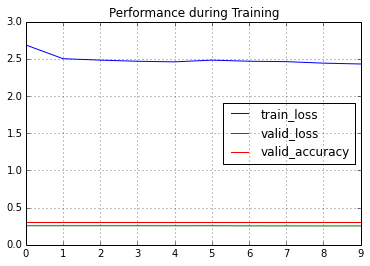

In [22]:
%matplotlib inline
perf[['train_loss','valid_loss','valid_accuracy']].plot(title='Performance during Training')

In [23]:
probs(X_val[0:10]),np.argmax(X_val[0:10], axis=1), y_val[0:10]

(array([[ 0.02764352,  0.02628479,  0.01885541,  0.02287088,  0.07707576,
          0.03561188,  0.02735219,  0.00849575,  0.01933375,  0.02321376,
          0.01439499,  0.05123205,  0.0622489 ,  0.03089152,  0.03661775,
          0.01318237,  0.37626788,  0.03908256,  0.01377889,  0.04675278,
          0.02881263],
        [ 0.02777688,  0.03029649,  0.02068442,  0.0244167 ,  0.07876992,
          0.04000157,  0.03016515,  0.00919801,  0.01891897,  0.02791033,
          0.01408748,  0.05496172,  0.05925034,  0.03395918,  0.03973318,
          0.01385091,  0.34407005,  0.03654079,  0.01552516,  0.05408347,
          0.02579927],
        [ 0.03036228,  0.01792865,  0.01538878,  0.02011583,  0.07907888,
          0.02471378,  0.02122433,  0.00909552,  0.0265069 ,  0.01309099,
          0.02111524,  0.04027713,  0.08546366,  0.02257629,  0.02723236,
          0.01491936,  0.38345408,  0.05359882,  0.01157298,  0.02782603,
          0.05445808],
        [ 0.02804004,  0.02520437,  0.01859